# Exercise 4: Gaussian processes

## Problem 1: Moodle quiz

Answer the quiz in Moodle.

You can write below brief justifications for your answers for the yes/no questions, especially if you are unsure of your reasoning or have trouble understanding exactly what is being asked. I can then consider giving you points even if the automatic grading considered the answer wrong. You can also show the calculations you did to get the numerical answers.

In [1]:
# imports

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import torch

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 10]

### Question 1

When evaluating a new value $f(x^*)$ we know that the conditional is given by:

$$p(f(x^*|\mathbf{f})) = \mathcal{N}(K_{x^*, \mathbf{x}}K_{\mathbf{x}, \mathbf{x}}^{-1}\mathbf{f}, K_{x^*, x^*} - K_{x^*, \mathbf{x}}K_{\mathbf{x}, \mathbf{x}}^{-1}K_{\mathbf{x}, x^*}$$

where $K$ denotes the covariance matrix whose entries are defined by the kernel. In our case, we use an RBF kernel with $\ell=1.5$, $\lambda=2$, $x^*=1$, $x=2$ and $f(x=2)=3$. Note that when we use a symmetric kernel, like RBF, $K_{\mathbf{x}, x^*} = K_{x^*, \mathbf{x}}$ Using the formula above, we have:

In [2]:
### Here be the justifications and calculations, if so desired

def rbf(x, x_p, l, lam):
    return lam*np.exp( -(x-x_p)**2 / (2*l**2) )

cross_k = rbf(2, 1, 1.5, 2)
x_k = rbf(2, 2, 1.5, 2)
x_star_k = rbf(1, 1, 1.5, 2)

print(f"Cross-covariance: {cross_k}")
print(f"Covariance in data: {x_k}")
print(f"Covariance in data to evaluate: {x_star_k}")

post_mu = cross_k*3/x_k
post_var = x_star_k - cross_k**2/x_k

print(f"Posterior mean: {post_mu}")
print(f"Posterior var: {post_var}")

Cross-covariance: 1.6014748058336161
Covariance in data: 2.0
Covariance in data to evaluate: 2.0
Posterior mean: 2.402212208750424
Posterior var: 0.7176392231400908


Adding observation noise to the model, we have:

$$p(f(x^*|\mathbf{y})) = \mathcal{N}(K_{x^*, \mathbf{x}}(K_{\mathbf{x}, \mathbf{x}}+\sigma^2\mathbf{I})^{-1}\mathbf{y}, K_{x^*, x^*} - K_{x^*, \mathbf{x}}(K_{\mathbf{x}, \mathbf{x}}+\sigma^2\mathbf{I})^{-1}K_{\mathbf{x}, x^*}$$

Where $\mathbf{y} = \mathbf{f} + \epsilon$ and $\epsilon ~ \mathcal{N}(0, \sigma^2)$. We can expect that on average $\mathbb{E}(\mathbf{y}) = \mathbf{f}$, since the noise is 0-mean; the average value of $\mathbf{y}$ is going to be $\mathbf{f}$.

To make this question easier to visualize, I will take a look at the 1-d case. Here, we would be adding a $\sigma^2$ term to the division, and $\sigma^2>0$, so the resulting mean will be smaller. On the other hand, the *subtracted* part of the final variance is divided by the additional $\sigma^2$ term, so the general variance term will be bigger.

### Question 2

See section 18.4 of the book

### Question 3

The smaller the length-scale parameter, the more "squiggly" our approximated function. This means that then a single observation doesn't really give us much information about the rest of the function; the values of the function are very highly uncorrelated, so we don't really learn how observations affect our inferred function very well. On the other hand, by setting $\ell \to \infty$, our covariance kernel returns pretty much a constant value for any pair of x's; the values are correlated over a long range. This is pretty much the basis for a linear model, for example in linear regression we are fitting a line using a training dataset, and we use this line to regress over unseen values.

### Question 4

By setting the hyperparameter $\sigma$ to 0, we are telling the model to assume that the observed $y$ was measured with no noise, so it will interpolate this datapoint perfectly.

### Question 5

The kernel we are using measures corellation as a function of distance, and it outputs very similar values for values that are close. They assume smoothness in the function, so if two points are close they will produce similar values.

### Question 6

The Gaussian Process is approximating a distribution in function space. This hints to the idea that it could be possible to have *other* types of distributions in function space; for example, this article published at the Proceedings of Machine Learning covers the usage of "Student-t processes":

https://proceedings.mlr.press/v33/shah14.html

It is known that the Student's t-distribution has heavier tails than Gaussian distributions, so trying to approximate it with a Gaussian distribution could cause misrepresentation at the tails (which in function space, I think, could translate to bigger mountains and throughs). A "true" posterior could therefore be hypothesized to exist with any distributional process, which would mean that we would be misrepresenting them with a Gaussian Process (for example if there is a multimodal distribution process).

Another possible case that I think could affect our model is hysteresis; the physical phenomenon that tells us that the properties that a material or object depends on its history. For example a rubber band's deformability is dependent on the strain it has faced in the past. Our model has no way to know the previous history for such a property, so we wouldn't be able to model effectively the posterior in cases where we don't have access to information from the past.

## Problem 2: GPs and marginal likelihood

You are given a data set of $x$ and $y$ pairs as defined below. Your task is to learn a good **Gaussian Process regression** model for this.

Use the RBF kernel
$$
k(x, x') = \lambda e^{-\frac{1}{2l^2} (x-x')^2}
$$
with normal likelihood
$$
p(y|f(x)) = \mathcal{N}(f(x), \sigma^2)
$$
where $\sigma^2$ is the noise variance.

The model has three hyperparameters, $l$, $\lambda$ and $\sigma$, and we will be inspecting their effect on the result.

Write code that:
1. Estimates the posterior distribution of the latent function $f(x)$ and evaluate it for the dense grid of test points x_test. You should do this so that it works for any choice of the hyperparameters. Note that much of this is already available in the lecture notebook.
2. Optimizes the hyperparameters by maximizing the **marginal likelihood** $p(y|x,l,\lambda,\sigma)$ of the available data. You can use gradient descent in PyTorch or some other technique (e.g. gradient descent with analytic derivatives, or even some black-box optimization routine).
3. Prints the optimal values and the resulting marginal likelihood.
4. Plots the function. Make a plot that shows (a) The mean estimate of f() for the test points (the grid over x-axis), (b) the uncertainty of f(), and (c) the uncertainty of $y$ for the test points. You should also plot the training data in the same plot so that the plots are easier to interpret.

Now use the code you wrote to study the effect of the hyperparameters, by showing the plots and marginal likelihoods for different choices of the hyperparameters. Start by showing the result with the optimal parameters and then proceed to show pairs of plots where you always make one parameter clearly smaller or larger. Label your plots clearly (with something like "Large observation noise" if using excessively large $\sigma$ etc) and **explain** how each of the parameters influences the result.


### Notes

As stated here: https://stats.stackexchange.com/questions/386813/use-the-rbf-kernel-to-construct-a-positive-definite-covariance-matrix

The RBF kernel is numerically unstable due to its fast exponential decay. Therefore, sometimes it is usual to add a small epsilon term to the diagonal of covariance matrices generated by the kernel to improve the matrix' condition number.

The uncertainty on the function mean estimate will be drawn with a filled-out area, while the observation error (the error estimated on the observed y) will be drawn with error bars, which will be 1.96 standard deviations up and down.

In [3]:
# THE DATA
x = torch.tensor([ 0.0504, -1.9066, -0.5220, -1.7397,  0.5151,  1.7474,  0.2499, -1.6334,
        -1.3278, -0.6832,  0.0248, -1.6533,  1.2656, -0.4293,  1.8606, -0.6216,
         0.2714,  0.0983, -0.6295, -1.1215,  1.8418,  1.6155,  1.9598,  1.8651,
         0.3304, -1.2396,  0.6092,  1.6508,  0.3112, -0.0261], dtype=torch.double)
y = torch.tensor([ 1.3866,  1.2162,  0.0608,  1.8141,  1.6938,  0.1754,  1.4721,  2.5264,
         2.4079,  0.7910,  1.1510,  1.8651,  0.9920,  0.0425,  0.4240,  0.8889,
         1.7757,  1.2457,  0.7961,  1.5359, -0.1856, -0.4273, -0.2238,  0.4841,
         1.5591,  1.8768,  1.4800,  0.4432,  1.7465,  1.7640], dtype=torch.double)
N = 30

# A REGULAR GRID OVER THE X-AXIS AS TEST POINTS
x_test = torch.linspace(-2.5, 2.5, 100)

# DEFINE THE KERNEL

# Simple RBF kernel with l controlling the smoothness
# and lam controlling the prior variance
def covMatrix(a, b, l=1.0, lam=torch.tensor([1.])):
    k = -0.5 * torch.square( a.reshape((len(a), 1)) - b.reshape((1, len(b))) )
    k /= l*l
    k += torch.log(lam)
    k = torch.exp(k)
    return k

# Compute the posterior with analytic expressions
# Epsilon term to avoid numerical instability due to the kernel
def posterior(y_obs, k_obs, k_pred, k_pred_obs, var = 1., epsilon = 1e-6):
    obs_len = k_obs.shape[0]
    pred_len = k_pred.shape[0]
    var_mat = var*torch.eye(obs_len)
    
    # Correction to avoid numeric instability
    k_obs += epsilon*torch.eye(obs_len)
    k_pred += epsilon*torch.eye(pred_len)
    
    inv_k_obs = torch.inverse(k_obs + var_mat)
    
    cov_matrix = k_pred - k_pred_obs @ inv_k_obs @ k_pred_obs.t()
    mean = k_pred_obs @ inv_k_obs @ y_obs
    return torch.distributions.multivariate_normal.MultivariateNormal(mean.flatten(), cov_matrix)

# Marginal likelihood
def log_marginal_likelihood(x, y, theta, epsilon=1e-6):
    # theta[0] = l
    # theta[1] = lam
    # theta[2] = var
    N = x.shape[0]
    
    k = covMatrix(x, x, theta[0], theta[1]) + epsilon*torch.eye(N)
    var_mat = theta[2] * torch.eye(N)
    
    return 0.5*(-N*torch.log(torch.tensor([2*np.pi])) - torch.log(torch.det(k + var_mat)) - (y_col.t()@torch.inverse(k+var_mat)@y_col)[0])

def plot_gp(distribution, obs_x=x, obs_y=y, obs_sigma=0., title="GP samples"):
    preds = distribution.mean
    sigma = torch.sqrt(distribution.variance)

    # for pred in preds:
    plt.plot(x_test, preds, 'k')

    plt.fill_between(x_test.ravel(), preds-1.96*sigma, preds+1.96*sigma, 
                     label=r"95% confidence interval", alpha=0.5, 
                     edgecolor='#DEF3FD', facecolor='#CC4F1B')
    plt.scatter(obs_x, obs_y, label="Observed Data")
    plt.errorbar(obs_x, obs_y, 1.96*obs_sigma, label="Observation Error", fmt="none")
    plt.title(title)
    plt.legend()
    plt.show()
    return

MLE estimates:  tensor(0.6425) tensor(1.4050) tensor(0.1097)
Log-likelihood at MLE:  tensor([-21.2775], dtype=torch.float64, grad_fn=<MulBackward0>)


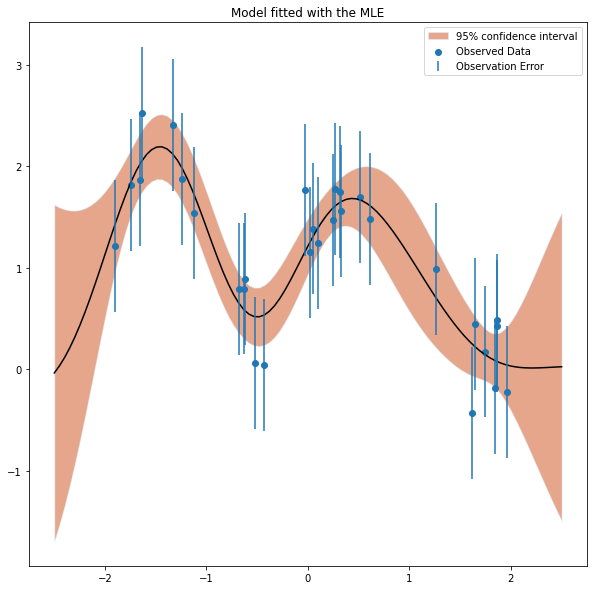

In [4]:
# Find optimal hyperparameters
# Note that you might want to optimize over log of these if using gradient descent
# l, lam, sigma = maximize_marginal_likelihood(...)

y_col = y.reshape((len(y), 1))

# Define the optimization algorithm
params = [torch.tensor([1.5, 2., 1.], requires_grad=True)]
optimizer = torch.optim.SGD(params, lr=1e-3)

# # Optimization loop
for i in range(5000):
    optimizer.zero_grad()
    loss = -log_marginal_likelihood(x, y_col, params[0])
    loss.backward()
    optimizer.step()

# Get the maximum value
mle_l, mle_lam, mle_var = params[0].detach()
print("MLE estimates: ", mle_l, mle_lam, mle_var)
theta_mle = torch.tensor([mle_l, mle_lam, mle_var])
print("Log-likelihood at MLE: ", log_marginal_likelihood(x, y, params[0]))

cov_obs = covMatrix(x, x, mle_l, mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l, mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l, mle_lam)

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-6)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var).numpy(), title="Model fitted with the MLE")

### Variation in length scale $\ell$

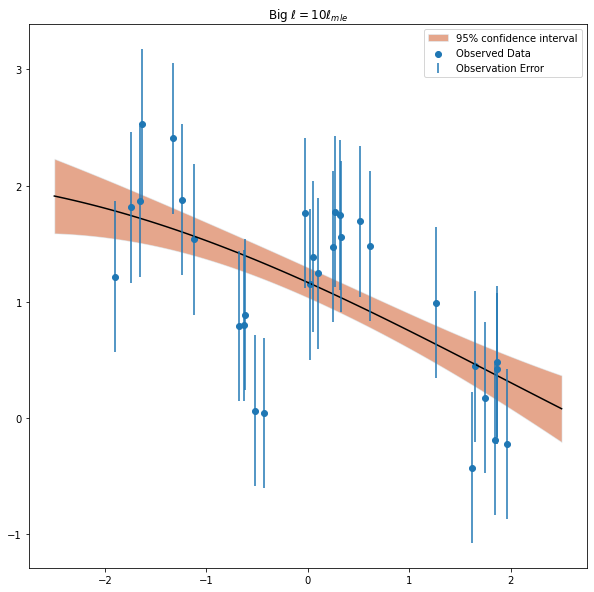

In [5]:
# PLOTS
# Plot the latent function, its uncertainty and the uncertainty of the predictions y
# Do this for the optimal hyperparameters and also for bad configurations

cov_obs = covMatrix(x, x, 10*mle_l, mle_lam)
cov_pred = covMatrix(x_test, x_test, 10*mle_l, mle_lam)
cov_pred_obs = covMatrix(x_test, x, 10*mle_l, mle_lam)

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-5)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var).numpy(), title="Big $\ell=10\ell_{mle}$")

As we were expecting from question 3 in exercise 1, a big value on the lengthscale parameter makes the resulting estimated function much smoother, making it "ignore" more of the noise in the observations. It makes the estimation closer to what we would observe using a linear model, giving a very smooth function that interpolates a linear model from the noisy data.

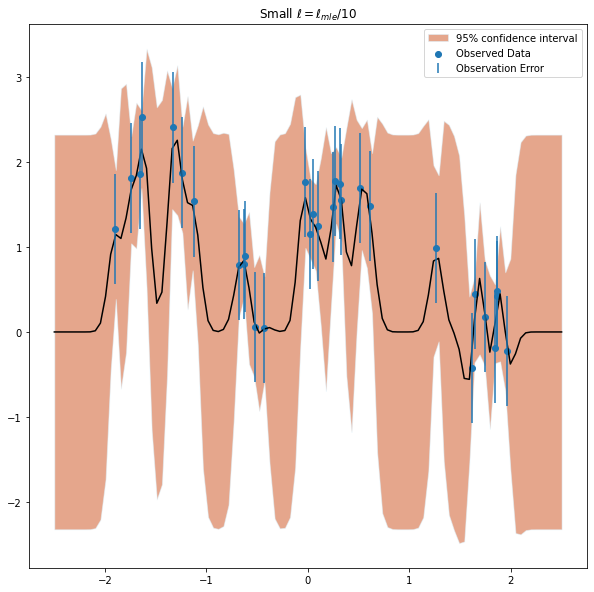

In [6]:
cov_obs = covMatrix(x, x, mle_l/10., mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l/10., mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l/10., mle_lam)

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-5)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var).numpy(), title="Small $\ell=\ell_{mle}/10$")

With a small lengthscale (10 times smaller than the MLE), we can see that the estimate becomes way more spiky, giving more weight to the actual observation. A small lengthscale means that different values become uncorrelated faster, so each datapoint will have a similar level of "importance" for our estimate. We can also see that outside of the training points, the mean estimate confidence interval grows considerably wider. This is because when we use a small lengthscale, we're telling the model that observed points give us little information when we stray away from them, so it's very difficult to interpolate useful information for unseen data.

### Variation in kernel variance $\lambda$

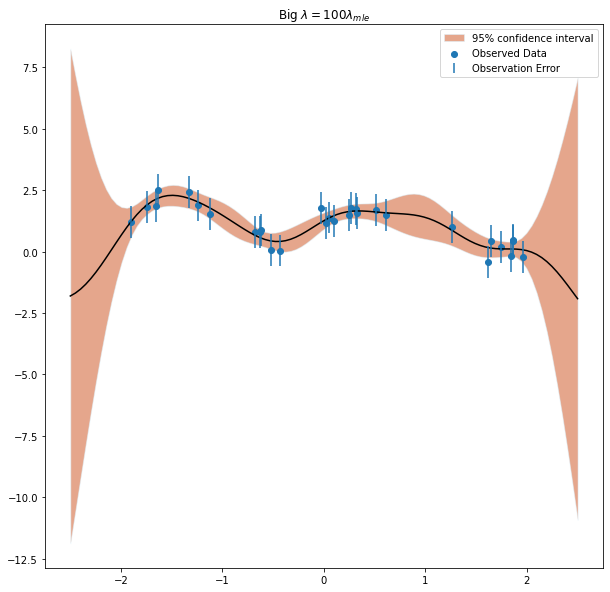

In [7]:
# PLOTS
# Plot the latent function, its uncertainty and the uncertainty of the predictions y
# Do this for the optimal hyperparameters and also for bad configurations

cov_obs = covMatrix(x, x, mle_l, 100*mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l, 100*mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l, 100*mle_lam)

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-3)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var).numpy(), title="Big $\lambda=100\lambda_{mle}$")

With a big $\lambda$, 100 times bigger than the MLE (which means that the standard deviation is 10 times bigger) we see that we tend to fit the curve more closely to our observations, but this results in a higher variance at the intervals where we don't have data (most obvious at the lateral ends of the function). This means that the model is fitting a lot to the observed data but will not give very good estimates for unobserved data, which naturally happens because we're telling the model that we believe that the function space distribution is very wide or uncertain.

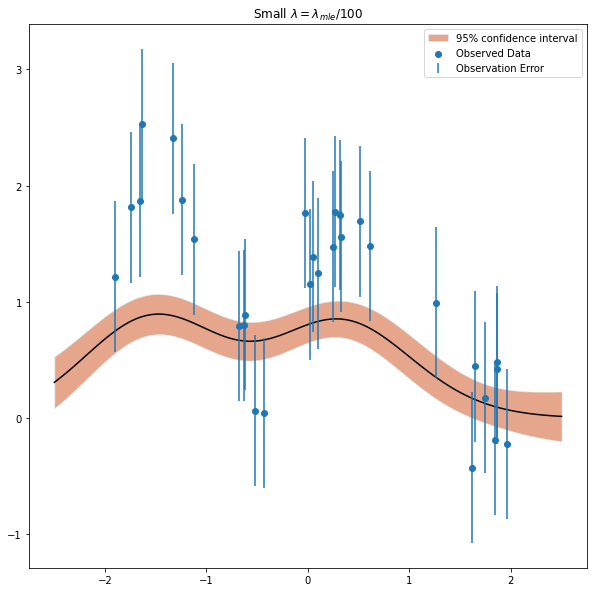

In [8]:
cov_obs = covMatrix(x, x, mle_l, mle_lam/100.)
cov_pred = covMatrix(x_test, x_test, mle_l, mle_lam/100.)
cov_pred_obs = covMatrix(x_test, x, mle_l, mle_lam/100.)

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var, 1e-5)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var).numpy(), title="Small $\lambda=\lambda_{mle}/100$")

With a small $\lambda$ we see that we barely are able to fit *some* datapoints within the curve. We are not able to capture the information from the data well enough with our model, and this comes from limiting a lot the exploration space of the kernel with a small variance. It's like we're trying to sample a huge space with a very small surrogate.

### Variation in observation noise $\sigma^2$

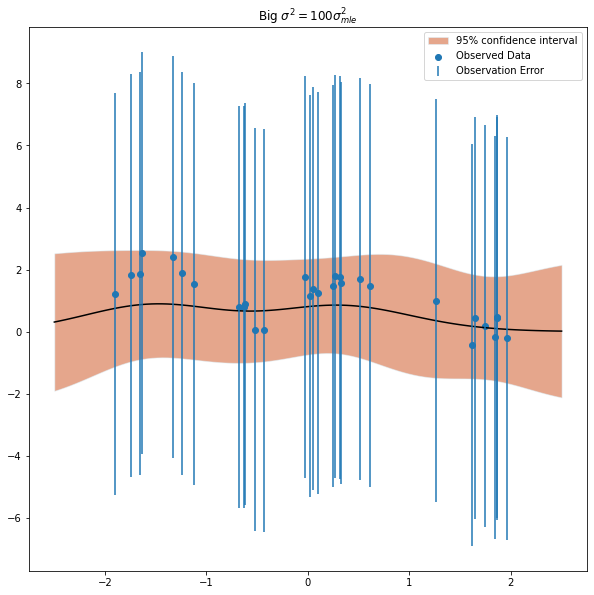

In [9]:
# PLOTS
# Plot the latent function, its uncertainty and the uncertainty of the predictions y
# Do this for the optimal hyperparameters and also for bad configurations

cov_obs = covMatrix(x, x, mle_l, mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l, mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l, mle_lam)

y_col = y.reshape((len(y), 1))

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, 100*mle_var, 1e-5)

plot_gp(post_test, obs_sigma=torch.sqrt(100*mle_var).numpy(), title="Big $\sigma^2=100\sigma^2_{mle}$")

With a big observation variance we can see how the fitted curve becomes a lot flatter, which comes from the fact that we're telling the model that we can't trust too much on the observations, since they're too noisy.

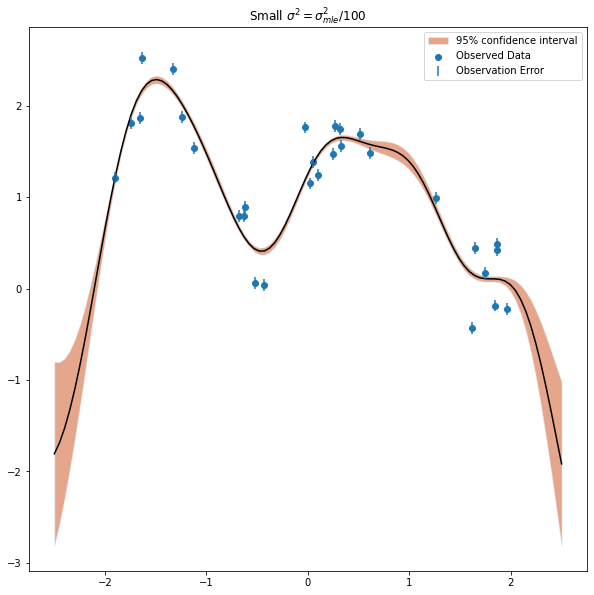

In [10]:
cov_obs = covMatrix(x, x, mle_l, mle_lam)
cov_pred = covMatrix(x_test, x_test, mle_l, mle_lam)
cov_pred_obs = covMatrix(x_test, x, mle_l, mle_lam)

y_col = y.reshape((len(y), 1))

post_test = posterior(y_col, cov_obs, cov_pred, cov_pred_obs, mle_var/100., 1e-5)

plot_gp(post_test, obs_sigma=torch.sqrt(mle_var/100.).numpy(), title="Small $\sigma^2=\sigma^2_{mle}/100$")

With a small observation variance we tell the model that the observations give us a lot of information, so the fitted line "deforms" more to accomodate better to the data's distribution. Since we're encoding that the measurements are more reliable the confidence interval also becomes a lot more narrow

## Problem 3: GPyTorch

In this exercise we practice using GPs with proper tools, rather than implementing inference from scratch.

We are given data that are pairs of univariate inputs $x$ and outputs $y$ that are constrained to be between zero and one. For instance, the input could be a dose of a drug (on some scale) and the output could be the probability that the drug has a positive effect in some population. We want to learn how $y$ depends on $x$ and realized we need a flexible model for this.

1. Start by reading the regression tutorial in https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html. 
2. Implement the model for the data provided below (using some kernel of your choice), using **exact inference** and **normal likelihood** for the observations. Do this so that you optimize over the kernel hyperparameters and report the results with an appropriate plot.
3. Change your code to use **variational approximation** but still use the normal likelihood. Check whether you get the same (or highly similar) result as with the exact inference. The documentation has clear pointers on how to do that, for instance in https://docs.gpytorch.ai/en/latest/examples/04_Variational_and_Approximate_GPs/Non_Gaussian_Likelihoods.html. Note that you now need to set both the model parameters and the likelihood parameters as trainable, since the likelihood parameters are no longer part of the model itself.
4. Continue with the variational approximation but now change the likelihood to **Beta distribution** so that you assume $y$ to be generated from a Beta distribution with the parameters
$$
    p(y|f) = \text{Beta}(s(f)b,(1-s(f))b)
$$
where $b$ is a scale parameter, $s()$ is the sigmoid function and $f$ is a latent function following a GP prior. Note that you do not need to implement this from scratch but the library has a direct implementation for the likelihood (see https://docs.gpytorch.ai/en/latest/likelihoods.html). Compare the result of modelling the data in this way with the previous results where you assumed normal likelihood for $y$ directly. What changed?

HINTS: 
- Whenever you plot something, remember to show also the uncertainty appropriately.
- Remember to write brief written explanation for what you see. How are the results different?
- The hyperparameter optimizer may sometimes converge to a local optimum where the data is modelled purely as noise. You can try to initialize the optimization routines better to avoid this, or you can try setting priors for these parameters. See https://docs.gpytorch.ai/en/latest/examples/00_Basic_Usage/Hyperparameters.html for examples on how to do this.
- For the Beta likelihood the parameter 's' is simply one extra hyperparameter. You can either leave it at some default value or give it a some prior and let the optimizer fit it. You should not use values that are very small since the latent function would then have very little effect -- for very small $s$ we just have uniform distribution over $y$ irrespective of $f$.

### Notes

I will be presenting uncertainty by plot 100 samples (in gray) on top of the mean estimate (in blue) and the observed data (black stars).

The data for this section presents a periodic pattern, so I will be using a periodic kernel as opposed to the RBF we have been using so far.

For problems 1 and 2, since we use a Gaussian likelihood, it's pretty simple to plot the observations' variance. In fact, as we can see in [the documentation](https://docs.gpytorch.ai/en/stable/likelihoods.html#gaussianlikelihood), the likelihood has a ```noise``` parameter that gives us the observation variance directly, so we can use this to plot the error bars directly (in this problem I use only one standard deviation).

Getting the error on the beta distribution is not as straightforward. First we note that a Beta distribution is usually parameterized as:

$$Beta(\alpha, \beta)$$

In this case, we have $\alpha=s\sigma(f)$ and $\beta=s(1-\sigma(f))$, so using these values we could use the formula for variance of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), given by:

$$\frac{\alpha\beta}{(\alpha+\beta)^2 (\alpha+\beta+1)}$$

In [11]:
import gpytorch

# OBSERVED DATA
train_x = torch.tensor([0.5126, 0.0233, 0.3695, 0.0651, 0.6288, 0.9368, 0.5625, 0.0917, 0.1680,
        0.3292, 0.5062, 0.0867, 0.8164, 0.3927, 0.9651, 0.3446, 0.5678, 0.5246,
        0.3426, 0.2196, 0.9605, 0.9039, 0.9900, 0.9663, 0.5826, 0.1901, 0.6523,
        0.9127, 0.5778, 0.4935, 0.5012, 0.6410, 0.4883, 0.9442, 0.2780, 0.2305,
        0.4002, 0.2337, 0.5585, 0.4633, 0.0507, 0.6100, 0.3050, 0.7710, 0.6987,
        0.2694, 0.3509, 0.1588, 0.9979, 0.0690, 0.7652, 0.2706, 0.2667, 0.5845,
        0.6084, 0.4865, 0.5080, 0.5669, 0.2378, 0.0224, 0.0600, 0.8233, 0.3634,
        0.9148, 0.2383, 0.9255, 0.3103, 0.7075, 0.3455, 0.6943, 0.2243, 0.9852,
        0.6694, 0.8797, 0.3302, 0.5267, 0.7142, 0.9162, 0.3036, 0.5128])
train_y = torch.tensor([0.9473, 0.9803, 0.6330, 0.9250, 0.3311, 0.9499, 0.8616, 0.9144, 0.3090,
        0.3811, 0.8733, 0.9124, 0.3459, 0.4235, 0.9813, 0.2945, 0.8940, 0.9254,
        0.3932, 0.2734, 0.9696, 0.9025, 0.9856, 0.9716, 0.8138, 0.2813, 0.2329,
        0.8965, 0.8364, 0.9311, 0.9089, 0.5626, 0.9586, 0.9882, 0.1046, 0.2527,
        0.7312, 0.2641, 0.8285, 0.8893, 0.9742, 0.4065, 0.2098, 0.1219, 0.1360,
        0.2983, 0.4822, 0.3533, 0.9649, 0.9614, 0.1990, 0.0884, 0.0490, 0.7147,
        0.6823, 0.9583, 0.8776, 0.9316, 0.0573, 0.9834, 0.9565, 0.3792, 0.6348,
        0.9224, 0.1689, 0.9594, 0.1974, 0.3019, 0.1805, 0.1727, 0.2434, 0.9776,
        0.3741, 0.8168, 0.3170, 0.9061, 0.1242, 0.8877, 0.1660, 0.9657])
N = 80

# SET OF TEST POINTS (AGAIN A GRID OVER THE INPUT AXIS)
test_x = torch.linspace(0.0, 1.0, 100)

### Exact inference with normal likelihood

In [12]:
# FOR EACH OF THE THREE MODELS YOU NEED ROUGHLY THE FOLLOWING
# 1. Specify kernel and likelihood, as well as the function that provides the marginal likelihood
# 2. Define the optimization problem: Tell what parameters are to be learned etc. Initialize with reasonable values if having trouble with convergence.
# 3. Maximize marginal likelihood
# 4. Switch to evaluation mode and make predictions for the test samples
# 5. Plot results, paying attention also to uncertainty

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel = gpytorch.kernels.PeriodicKernel() # gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
model = ExactGPModel(train_x, train_y, likelihood, kernel)

training_iter = 5000

# Find optimal model hyperparameters
model.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


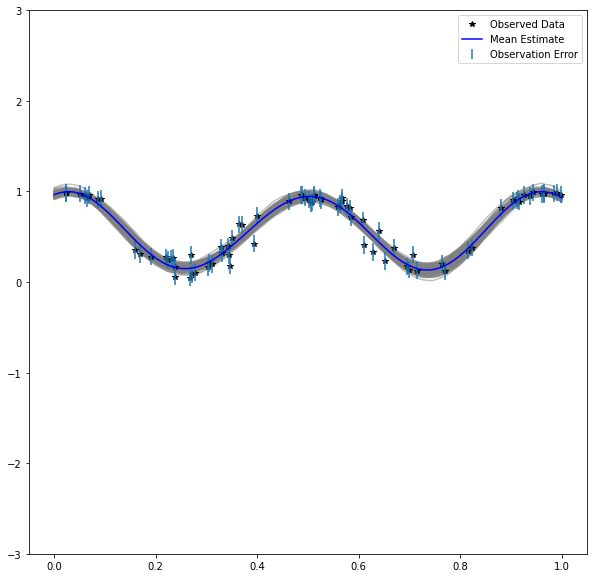

In [13]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix

n_sample = 100

f_samples = f_preds.sample(sample_shape=torch.Size([n_sample,]))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    ax.plot(test_x.numpy().T, f_samples.numpy().T, 'gray', alpha=0.5)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Observed Data")
    plt.errorbar(train_x, train_y, torch.sqrt(likelihood.noise), label="Observation Error", fmt="none")
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_mean, 'b', label="Mean Estimate")
    ax.set_ylim([-3, 3])
    ax.legend()

We can see that the mean estimate fits the data pretty well, with a high level of confidence since all the samples present a tight range around the mean. The periodic kernel seems to be able to fit the model pretty well under the Gaussian assumption, and we have a very tight bound on the observation variance thanks to the analytical solution.

### VA with Gaussian likelihood

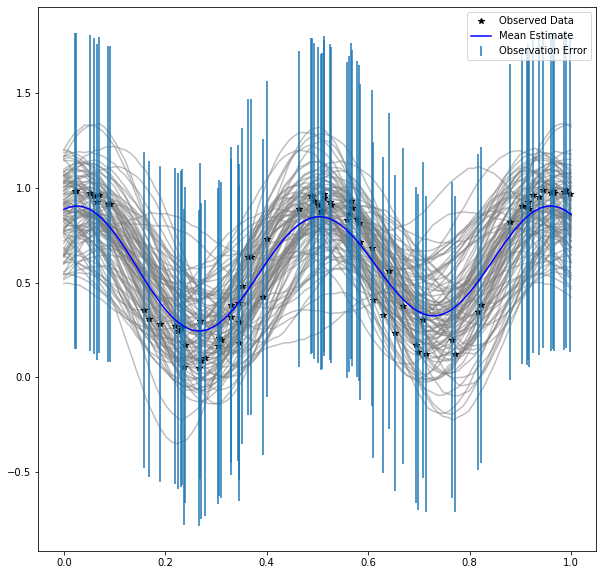

In [14]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.PeriodicKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

training_iter = 5000

for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Go into eval mode
model.eval()
likelihood.eval()

f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean

n_sample = 100
f_samples = f_preds.sample(sample_shape=torch.Size([n_sample,]))

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Get upper and lower confidence bounds
    lower, upper = y_preds.confidence_region()
    ax.plot(test_x.numpy().T, f_samples.numpy().T, 'gray', alpha=0.5)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Observed Data")
    # Plot predictive means as blue line
    plt.errorbar(train_x, train_y, torch.sqrt(likelihood.noise), label="Observation Error", fmt="none")
    ax.plot(test_x.numpy(), f_mean.numpy(), 'b', label="Mean Estimate")
    ax.legend()


In this case we can see a lot more variability with the samples and less confidence on the observations. We can also see that the mean estimate is a bit "squished down", which could be attributed to variational inference tending to penalize surrogate distributions hard when they produce non-zero values where the original distribution is close to zero, which could lead to the function being a bit underestimated. The observed variability in the samples could be due to the use of an optimization algorithm on noisy data; we are fitting a model to data with an unknown amount of noise (which we also have to try to estimate at the same time) using a stochastic gradient method.

### VA with Beta likelihood

In [15]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.PeriodicKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BetaLikelihood(scale_prior = gpytorch.priors.GammaPrior(5., 5.0))

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

training_iter = 5000

for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Go into eval mode
model.eval()
likelihood.eval()

BetaLikelihood(
  (quadrature): GaussHermiteQuadrature1D()
  (scale_prior): GammaPrior()
  (raw_scale_constraint): Positive()
)

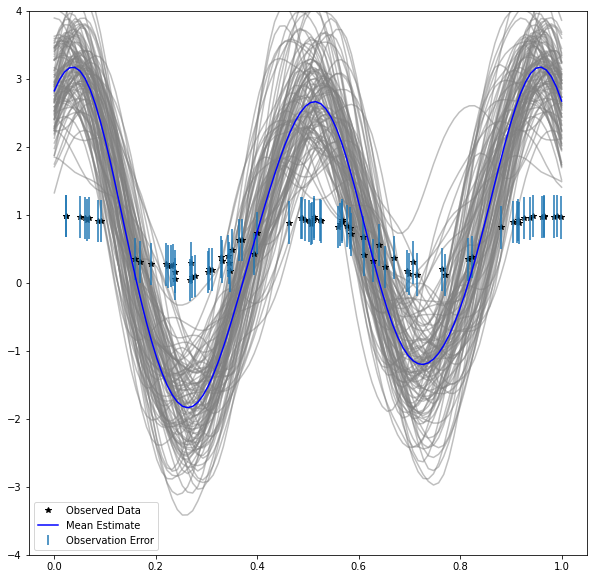

In [16]:
f_preds = model(test_x)
y_preds = likelihood(model(test_x))

f_mean = f_preds.mean

n_sample = 100
f_samples = f_preds.sample(sample_shape=torch.Size([n_sample,]))

with torch.no_grad():
    # Initialize plot
    sig_f = torch.sigmoid(train_y)
    alpha = likelihood.scale*sig_f
    beta = likelihood.scale*(1-sig_f)
    var = alpha*beta/( (alpha+beta)**2*(alpha+beta+1) )
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    ax.plot(test_x.numpy().T, f_samples.T, 'gray', alpha=0.5)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Observed Data")
    plt.errorbar(train_x, train_y, torch.sqrt(var.mean()), label="Observation Error", fmt="none")
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_mean, 'b', label="Mean Estimate")
    ax.set_ylim([-4, 4])
    ax.legend()

Here, as opposed to the previous case, we can see that the fitted model *overshoots* the amplitude of the distribution. This could be due to the implicit beliefs we're encoding into our model by using a Beta likelihood; the beta distribution concentrates all its probability mass within the range of $[0, 1]$, which in this case is done by compressing our domain using a sigmoid function. The compression is non-linear, which can give more importance to the central range of values, and then we scale back up using the scale parameter $s$, which can result in a lot of the probability mass assigned to the "hot spots" being amplified considerably more, which could explain what we're seeing here. However we see a higher confidence interval on the observations, which could be because of them being used or studied more under the "compressed" domain of the sigmoid. To verify this, we can try to scale down the resulting mean estimate with the standard deviation (in this case, for simplicity, I will use the average variance for scaling down the samples and mean estimate):

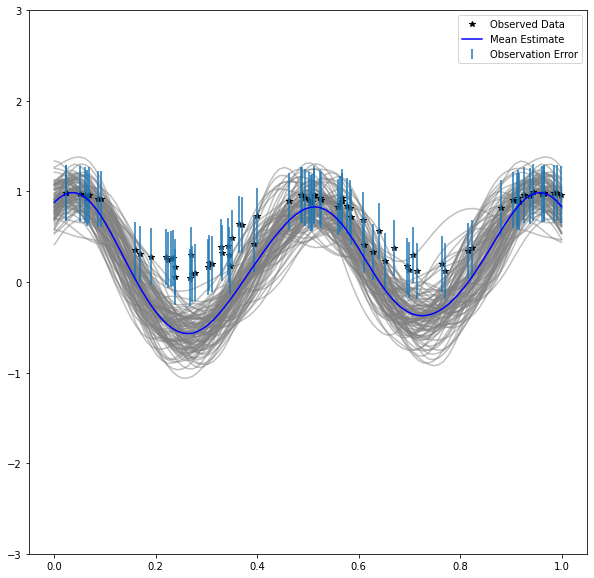

In [17]:
with torch.no_grad():
    # Initialize plot
    sig_f = torch.sigmoid(train_y)
    alpha = likelihood.scale*sig_f
    beta = likelihood.scale*(1-sig_f)
    var = alpha*beta/( (alpha+beta)**2*(alpha+beta+1) )
    f, ax = plt.subplots(1, 1, figsize=(10, 10))

    ax.plot(test_x.numpy().T, f_samples.T*torch.sqrt(var.mean()), 'gray', alpha=0.5)
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', label="Observed Data")
    plt.errorbar(train_x, train_y, torch.sqrt(var.mean()), label="Observation Error", fmt="none")
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), f_mean*torch.sqrt(var.mean()), 'b', label="Mean Estimate")
    ax.set_ylim([-3, 3])
    ax.legend()

The range of y-values is much closer to the data than before, and we can see that sections of the estimate (particularly the left valley) are considerably lower than the data. This could again be attributed to variational approximation penalizing when the approximation has a big value when the true distribution is close to 0, and this could be magnified by the rescaling. I'm not completely sure as for why the mean estimate needed to be rescaled in this case to approximate the data better, though I'm guessing it's due to particularities of using a Beta distribution as the likelihood. Compressing the information could also have had an influence in reducing the confidence interval on the mean estimate, since the bounds look tighter than on the previous case where we used VI with a Gaussian likelihood.